<br/><br/><br/><br/>

### Задача #1
Сервис Яндекс.Еда привлекает новых клиентов в том числе с помощью скидок. При этом для повышения экономической эффективности необходимо отслеживать основные метрики по скидкам. Напишите код, который отвечает на следующие вопросы (можно использовать SQL или Python):

1.	Какая доля заказов с промокодами?
2.	Самый популярный (в метрике суммы скидки) промокод (название) и сумма скидки по нему?

Данные, которые есть (для простоты в формате **.txt**, несколько первых строк):<br/>
**orders.txt** (если в заказе был промокод, то записываеся **id** промокода; если не было, то **NULL**)<br/>
>order_id, promocode_id<br/>
>1,23<br/>
>2,NULL<br/>
>3,5<br/>

**promocodes.txt** (**discount** – сумма скидки в рублях)<br/>
>promocode_id, name, discount<br/>
>1,hello,300<br/>
>2,eda,500<br/>

### Решение:
1. Просто для удобства работы, допустим, что мы выгружаем в **.csv**, а не в **.txt**.<br/>
*Примечание: это не критично, могу написать код и для* **.txt**
2. Если я правильно понял условие "Самый популярный (в метрике суммы скидки)", это означает "промокод, с максимальной по всем заказам суммарной величиной скидки"
<br/><br/><br/><br/>

In [55]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def promo_ratio(n):
    """Доля заказов с промокодами"""
    if len(n)==0:
        return 'Error: array is empty'
    N = len(n)
    nan_rate = np.sum([1 for i in orders['promocode_id'] if np.isnan(i)])
    return (N-nan_rate)/N

def addv(d,v):
    """Добавляет в словарь"""
    if v in d:
        d[v]+=1
    else:
        d[v]=1
        
def popular(order,promos):
    """Возвращает имя промокод, с максимальной по всем заказам суммарной величиной скидки и величину этой скидки"""
    d = dict() # создать словарь
    # вычислить для каждого промокода количество его появлений
    for i in orders['promocode_id']: 
        if np.isnan(i)==False:
            addv(d,i) 

    # заменить id промокода на name, суммарная скидка = количество*сумма_скидки
    for i,name,disc in promos.values:
        if i in d:
            d[name] = d.pop(i)
            d[name] *= disc
    return max(d, key=d.get), max(d.values())

In [2]:
if __name__ == '__main__':
    orders = pd.read_csv("orders.csv")
    promos = pd.read_csv("promocodes.csv")
    print("Доля заказов с промокодами:", promo_ratio(orders['promocode_id']))
    print("Промокод и суммарная скидка:", *popular(orders,promos))

Доля заказов с промокодами: 0.6666666666666666
Промокод и суммарная скидка: test 200


<br/>
<br/>
<br/>
<br/>
<br/><br/>

### Задача #2
Яндекс.Еда осуществляет доставку еды из ресторанов. При этом у каждого ресторана есть зона, в рамках которой осуществляется доставка. Зона представляет собой полигон из координат. Пользователь в зависимости от своей координаты видит разное количество доступных ресторанов. Нам важно, чтобы у каждого пользователя было достаточное количество ресторанов для выбора. Задача заключается в том, чтобы по каждой координате пользователя посчитать доступное ему количество ресторанов. Можно использовать Python.<br/>
Данные, которые есть (для простоты в формате **.txt**, несколько первых строк):

**user_coordinates.txt** (примерно 300 тыс строк, **user_id** – идентификатор пользователя)<br/>
>**user_id,loc_lat,loc_lon**<br/>
>1,55.737564,37.345186<br/>
>2,56.234564,37.234590<br/>
>3,55.234578,36.295745<br/>

**place_zone_coordinates** (примерно 500 тыс строк, **place_id** – идентификатор ресторана, **point_number** – порядковый номер точки в зоне доставки ресторана)<br/>
>**place_id,loc_lat,loc_lon, point_number**<br/>
>1,55.747022,37.787073,0<br/>
>1,55.751713,37.784328,1<br/>
>1,55.753878,37.777638,2<br/>
>1,55.751031,37.779351,3<br/>
>2,55.803885,37.458311,0<br/>
>2,55.808677,37.464054,1<br/>
>2,55.809763,37.461314,2<br/>
>2,55.810840,37.458654,3<br/>


**Формат результата:**<br/>
>**id,number_of_places_available**<br/>
>1,2<br/>
>2,19<br/>
>3,0<br/>


### Решение:
1. Также как и ранее, для удобства работы, допустим, что мы выгружаем в **.csv**, а не в **.txt**.<br/>
2. Для таблицы **place_zone_coordinates** будем предполагать, что область задается 4 точками. Я понимаю, что в общем случае количество точек может быть задано от 3 до n, но алгоритмы для каждого случая будут отличаться не значительно. 
<br/>

**Основная идея состоит в следующем:** <br/>
* Давайте вычислим заранее площади всех областей: каждая область это 4-угольник ABCD, состоящий из треугольников таких, что $2*S_{ABCD} = S_{ABC}+S_{BCD}+S_{CDA}+S_{DAB}$
* Далее, для каждой точки-координаты пользователя $O(x,y)$ вычислим ту же площадь 4-угольника ABCD, как  $S_{ABCD} = S_{OAB}+S_{OBC}+S_{OCD}+S_{ODA}$
* И если площади вычисленные обоими способами равны - значит точка $O(x,y)$ находится внутри области 4-угольника
* Повторим следующее для всех пользователей

**Минусы этого метода:**<br/>
Основной минус - это вычисления с плавающей точкой. На этапе сравнения площадей мы можем судить о равенстве двумя методами лишь с определенной точностью. Поэтому я задал точность на 3 порядок выше чем точность с которой у нас заданы координаты (тоесть 10 знаков после запятой)
<br/><br/><br/><br/>

In [95]:
def place_xy(place):
    """возвращает координаты X,Y для всех  places"""
    px = np.zeros((int(len(place)/4),4), dtype='float128')     # place area X-coord.
    py = np.zeros((int(len(place)/4),4), dtype='float128')     # place area Y-coord.
    prev, ind = place['place_id'][0], 0
    for i,x,y,n in place.values:
        n = int(n)
        if prev==i:
            px[ind][n] = x
            py[ind][n] = y
        else:
            prev,ind = i, ind+1
            px[ind][n] = x
            py[ind][n] = y
    return px, py

##########  вычисление площади 4-угольника без user
def d(x2,x1,y2,y1):
    """вычисляет расстояние между точками"""
    return np.sqrt((x2-x1)**2+(y2-y1)**2)

def s3(t1,t2,t3,px,py):
    """вычисляет S треуг."""
    abc = np.array([t1,t2,t2,t3,t3,t1]).reshape(-1,2) # генератор пар точек 
    a,b,c = [d(px[:,i],px[:,j],py[:,i],py[:,j]) for i,j in abc]   # длины сторон треугольника
    p = (a+b+c)/2   # полпериметра
    s = np.sqrt(p*(p-a)*(p-b)*(p-c))
    return s

def p_s4(px,py):
    """вычисляет площадь 4-угольника как половина суммы площадей его треугольников"""
    abcd = np.array([0,1,2,1,2,3,2,3,0,3,0,1]).reshape(-1,3)
    s_1,s_2,s_3,s_4 = [s3(t1,t2,t3,px,py) for t1,t2,t3 in abcd]
    s = (s_1+s_2+s_3+s_4)/2
    return s
############


##########  вычисление площади 4-угольника с user
def user_xy(user):
    """возвращает координаты X,Y для всех  user"""
    ux = np.zeros((int(len(user)),1), dtype='float128')     # user X-coord.
    uy = np.zeros((int(len(user)),1), dtype='float128')         # user Y-coord.
    u_id = np.zeros(int(len(user)), dtype='int').reshape(-1,1)     # user id
    for ind,(i,x,y) in enumerate(user.values):
        ux[ind]=x
        uy[ind]=y
        u_id[ind]=i
    return ux, uy, u_id

def s3_u(t1,t2,px,py,uxi,uyi):
    """Вычисляет S треуг. образующийся из точек t1,t2 и коорд. user'а"""
    a = d(px[:,t1],uxi,py[:,t1],uyi)
    b = d(uxi,px[:,t2],uyi,py[:,t2])
    c = d(px[:,t2],px[:,t1],py[:,t2],py[:,t1])
    p = (a+b+c)/2   # полпериметра
    s = np.sqrt(p*(p-a)*(p-b)*(p-c))
    return s

def s4_u(px,py,uxi,uyi):
    """вычисляет площадь 4-угольника как сумму 4-х треугольников"""
    abcd = np.array([0,1,1,2,2,3,3,0]).reshape(-1,2)
    s_1,s_2,s_3,s_4 = [s3_u(t1,t2,px,py,uxi,uyi) for t1,t2 in abcd]
    s = (s_1+s_2+s_3+s_4)
    return s
##########

def eq(a, b, eps):
    """функция сравнения двух чисел с точностью eps"""
    if abs(a-b)<eps:
        return True
    else:
        return False
    
def n_available(S1,S2):
    """Сравнивает и возвращает количество одинаковых площадей для"""
    n = 0 
    eps = 0.0000000001
    for i in range(len(S1)):
        if eq(S1[i],S2[i],eps):
            n+=1
    return n

In [96]:
place = pd.read_csv("place_zone_coo.csv")
user = pd.read_csv("user_coo.csv")
user.head()

,user_id,loc_lat,loc_lon
0,1,55.737564,37.345186
1,2,56.234564,37.234590
2,3,55.234578,36.295745
3,4,0.123411,0.132513
4,5,55.752125,37.780123


In [97]:
px, py = place_xy(place)                # places X,Y coord.
ux, uy, u_id = user_xy(user)            # users X,Y coord. and user id's
S1 = p_s4(px,py)                        # S without user
df = pd.DataFrame(columns=['user_id', 'number_of_places_available'])
for i in range(len(u_id)):
    uxi = np.array([ux[i]]*int(len(px))).reshape(-1)
    uyi = np.array([uy[i]]*int(len(px))).reshape(-1)
    S2 = s4_u(px,py,uxi,uyi)            # S with user_i
    df = df.append({'user_id': u_id[i][0], 'number_of_places_available': n_available(S1,S2) },ignore_index=True)

In [98]:
df

,user_id,number_of_places_available
0,1,0
1,2,0
2,3,0
3,4,1
4,5,1
5,6,0


In [56]:
################ микро-проверки для себя

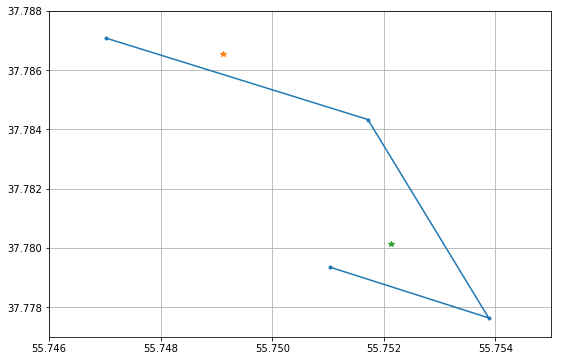

In [100]:
plt.figure(figsize=(9, 6))

plt.plot(px[0], py[0], '.-')
plt.plot(ux[5],uy[5],'*') # user6 - outside
plt.plot(ux[4],uy[4],'*') # user5 - inside
plt.xlim(55.746, 55.755)
plt.ylim(37.777, 37.788)
plt.grid(True)

<br/>
<br/>
<br/>
<br/>
<br/><br/>

### Задача #3
Мы в Яндекс.Еде любим поиграть в покер и настольные игры. Поэтому нам важно, чтобы будущие коллеги были сильны в математической статистике и теории вероятностей (так интереснее играть))) Если серьезно, то в большинстве аналитических задач у нас возникает необходимость применять математический аппарат в том или ином виде. Проще всего его проверить через учебные игровые задачи, чтобы не погружать в сложный контекст бизнеса. <br/>
Вы подбрасываете кубик (6 граней), после чего у вас есть две возможности: <br/>
    1. Взять себе сумму $, равную выпавшему на кубике числу (выпало 3 – получаете 3$)
    2. Отклонить результат первого броска и подбросить кубик второй раз. После чего уже взять себе столько $, сколько выпало во второй раз (второй бросок отклонять уже нельзя)
Какую стратегию нужно выбрать, чтобы максимизировать ожидаемую прибыль (при каких значениях первого броска нужно перебрасывать?) <br/>
Почему эта стратегия максимизирует прибыль?<br/>
Чему равна ожидаемая прибыль при этой стратегии (математическое ожидание)?<br/>
<br/>
<br/>
<br/>
<br/>
<br/><br/>

### Решение:
Любая стратегия выигрышная. Какое бы "пороговое" значение мы не выбрали, мы всегда будем стремиться к среднему значению. <br/>
Так как все события независимы, равномерно распределённые, а вероятность выпадения k не увеличивается и не уменьшается при перебрасывании кубика после выпадении k и ниже. <br/>
Средняя прибыль за один бросок равна $mean = 1/6*1+1/6*2+1/6*3+1/6*4+1/6*5+1/6*6=3.5$<br/>
Ожидаемая прибыль стремиться к $mean*N$, где N - количество шагов (1 шаг в результате получения суммы)<br/>
